# Simulation of a Prescribed Fire policy 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import rioxarray
from tqdm import tqdm
from prescribed.utils import prepare_template
from rasterio import transform
from prescribed.utils import expand_grid, grouper
from prescribed.plot import template_plots

from prescribed.estimate.simulations import (
    simulation_data, 
    sample_rx_years, 
    run_simulations
)

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

In [4]:
policy_size = 1_000_000
size_rx = 2_000

print(f"Number of policy 1 sq-km pixels: {policy_size / 247.105}")
print(f"If all fires are of {size_rx} acres, then the size is: {size_rx / 247.105} sq-km")
print(f"Number of fires in the policy area: {policy_size / size_rx}")

Number of policy 1 sq-km pixels: 4046.8626697153036
If all fires are of 2000 acres, then the size is: 8.093725339430607 sq-km
Number of fires in the policy area: 500.0


In [10]:
sim_data = simulation_data(
    template="/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif", 
    land_type="/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather", 
    roads=["/mnt/sherlock/oak/prescribed_data/raw/os_roads_ca/norcal/gis_osm_roads_free_1.shp",
           "/mnt/sherlock/oak/prescribed_data/raw/os_roads_ca/socal/gis_osm_roads_free_1.shp"
           ],
    only_roads = False,
    buf=10_000,
    road_type="secondary",
)

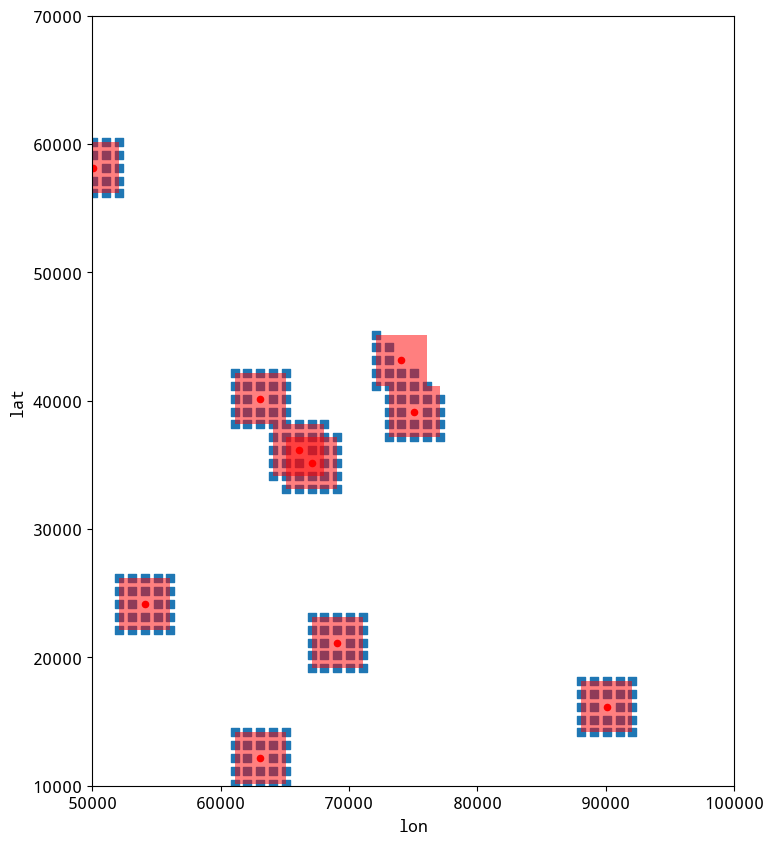

In [6]:
# Sim data as a geodataframe
sim_data = gpd.GeoDataFrame(sim_data, 
                            geometry=gpd.points_from_xy(
                                sim_data.lon, sim_data.lat))
sim_data = sim_data.set_crs(epsg=3310)

# Get a sample of the points
sim_data_sample = sim_data[(sim_data["land_type"] == 2) &
                           (sim_data.lon > 50000) & (sim_data.lon < 100000) &
                           (sim_data.lat > 10000) & (sim_data.lat < 70000)].sample(10)

# Transform to geopandas and then buffer the points
sim_data_gpd = gpd.GeoDataFrame(sim_data_sample, 
                            geometry=gpd.points_from_xy(
                                sim_data_sample.lon, sim_data_sample.lat))
sim_data_gpd = sim_data_gpd.set_crs(epsg=3310)


# Buffer the points to 5 km
sim_data_gpd["geometry"] = sim_data_gpd.buffer(2000, cap_style="square")


# Filter points that overlap with the buffered points
sample_complete = sim_data.overlay(sim_data_gpd.drop(columns=["lat", "lon", "grid_id"], errors="ignore"), how="intersection")

sample_complete = sample_complete.drop_duplicates(subset=["grid_id"])

sample_complete = sample_complete[~sample_complete.grid_id.isin(sim_data_sample.grid_id)]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

sample_complete.plot(ax=ax, marker="s")

# Plot sampled points
sim_data_sample.plot.scatter(x='lon', y='lat', ax=ax, color="red")

# Plot the buffered points
sim_data_gpd.plot(ax=ax, color="red", alpha=0.5)

# Set limits of the plot
ax.set_xlim(50000, 100000)
ax.set_ylim(10000, 70000)

plt.show()

In [11]:
sim_data

,lat,lon,grid_id,land_type
0,449152.596997,-348913.82085,941,2.0
1,449152.596997,-347913.82085,942,2.0
2,449152.596997,-346913.82085,943,2.0
3,449152.596997,-345913.82085,944,2.0
4,449152.596997,-344913.82085,945,2.0
...,...,...,...,...
409164,-602847.403003,280086.17915,965202,5.0
409165,-602847.403003,281086.17915,965203,5.0
409166,-603847.403003,271086.17915,966109,4.0
409167,-603847.403003,272086.17915,966110,12.0


In [12]:
template = prepare_template("/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif")

dnbr = pd.read_feather("/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather")
mtbs = gpd.read_file("/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp").to_crs("EPSG:3310")

# Merge it to get years
mtbs["year"] = mtbs.Ig_Date.dt.year

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")]

dnbr = dnbr.merge(mtbs[["Event_ID", "year"]], right_on="Event_ID", left_on="event_id", how="left")
dnbr.drop(columns=["Event_ID"], inplace=True)

# Merge with template to add all the grids
#dnbr = template.merge(dnbr.drop(columns=["lat", "lon"]), on=["grid_id", "year"], how="left")

# # Solve overlapping repeats by taking the max
#dnbr = dnbr.set_index(["lat", "lon", "year"])

# Create xarray object
#dnbr_arr = dnbr[~dnbr.index.duplicated()].dnbr.to_xarray()

In [13]:
# Prepare results
results = pd.read_csv("../data/results/att_conifers_dnbr.csv")
results["land_type"] = results.land_type.replace({"conifers": 2.0, "shrublands": 12.0})

spillover_results = pd.read_csv("../data/results/att_spillover.csv")
spillover_results = (spillover_results[spillover_results.dist_treat == 2000]
                     .drop(columns='dist_treat', errors="ignore")
                     .sort_values("year")
)

sim_data = sim_data[sim_data.land_type.isin([2])]

# Prepare fire data
fire_data = (
    pd.read_feather("/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather")
    .drop(columns=["spatial_ref"], errors="ignore")
)
fire_data = fire_data[fire_data.year >= 2010]

# Prepare template
template = prepare_template("/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif", 
                            years=[2000, 2022])
template = gpd.GeoDataFrame(template, 
                            geometry=gpd.points_from_xy(template.lon, template.lat), 
                            crs = "EPSG:3310")
template = template[template.year >= 2010]

In [21]:
test_sample = sample_rx_years(
    template = template, 
    treat_data = sim_data,
    fire_data = fire_data,
    estimates = results,
    size_treatment = 1_000,
    spillovers=True,
    spillover_size=2_000,
    spillover_estimates=spillover_results,
    start_year=2010,
    sample_n=100,
)

In [22]:
test_sample

,grid_id,year,land_type,lat,lon,coef,low_ci,high_ci,se,year_treat,coeff
0,85342,2011,2.0,357152.596997,-219913.82085,-87.614692,-137.651961,-37.577424,25.529219,2010,-78.093571
1,723103,2011,2.0,-338847.403003,5086.17915,-87.614692,-137.651961,-37.577424,25.529219,2010,-99.685757
2,194288,2011,2.0,238152.596997,-277913.82085,-87.614692,-137.651961,-37.577424,25.529219,2010,-79.706546
3,80750,2011,2.0,362152.596997,-231913.82085,-87.614692,-137.651961,-37.577424,25.529219,2010,-75.475515
4,461187,2011,2.0,-52847.403003,65086.17915,-87.614692,-137.651961,-37.577424,25.529219,2010,-99.516275
...,...,...,...,...,...,...,...,...,...,...,...
1971,926778,2022,spillover,-559847.403003,328086.17915,-34.045054,-65.014878,-3.075231,15.800930,2021,-31.097286
1972,926779,2022,spillover,-559847.403003,328086.17915,-34.045054,-65.014878,-3.075231,15.800930,2021,-79.539489
1973,926780,2022,spillover,-559847.403003,328086.17915,-34.045054,-65.014878,-3.075231,15.800930,2021,-25.880892
1974,927695,2022,spillover,-559847.403003,328086.17915,-34.045054,-65.014878,-3.075231,15.800930,2021,-34.680552


In [33]:
run_simulations(
    template = template,
    sim_data = sim_data,
    results = results,
    fire_data = fire_data,
    save_path= "../data/simulations_treat_parquet_spillover",
    num_sims = 100,
    step_save = 10,
    dims = ["lat", "lon", "year", "year_treat"],
    size_treatment=1_000,
    start_year=2010,
    sample_n=4_000,
    crs="EPSG:3310",
    format="parquet",
    spillovers=True,
    spillover_size=2_000,
    spillover_estimates=spillover_results
)

Grouping simulations:   0%|          | 0/10 [00:00<?, ?it/s]

Grouping simulations: 100%|██████████| 10/10 [16:47<00:00, 100.73s/it]


### Read simulations

In [34]:
import duckdb

dnbr = dnbr[dnbr.year > 2010]
dnbr["low_severity"] = np.where((dnbr.dnbr <= 270) & (dnbr.dnbr > 100), 1, 0)
dnbr["high_severity"] = np.where((dnbr.dnbr > 660), 1, 0)

# Read in all the sims to merge with dnbr data
df = duckdb.query("""
with sim as (
SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
FROM '../data/simulations_treat_parquet_spillover/*.parquet'
WHERE land_type IS NOT NULL) 
SELECT d.grid_id,
       d.year, 
       s.year_treat, 
       s.coeff, 
       s.sim, 
       d.dnbr, 
       s.coeff + d.dnbr as sim_dnbr,
       d.low_severity,
       d.high_severity
from sim s
right join (SELECT grid_id, year, dnbr, low_severity, high_severity FROM dnbr) as d
ON s.grid_id = d.grid_id AND s.year = d.year
""")

# Aggregated data by year and year_treat to plot
df_year_treat = duckdb.query("""
select year, year_treat, mean(coeff) as coeff_mean
from df
group by year, year_treat
""")

# Aggregated data by year and sim to plot
df_year_treat_sim = duckdb.query("""
select year, year_treat, sim, mean(coeff) as coeff_mean
from df
group by year, year_treat, sim
""")


<Axes: xlabel='Year', ylabel='Simulated change in $\\Delta$NBR'>

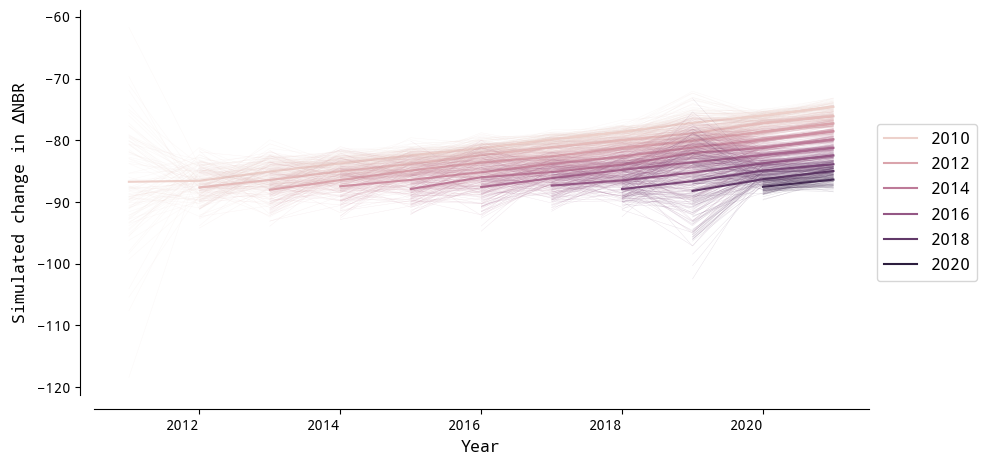

In [35]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(
    data = df_year_treat.to_df(),
    x="year", 
    y="coeff_mean", 
    hue="year_treat",
    ax=ax
)

sns.lineplot(
    data = df_year_treat_sim.to_df(),
    x="year", 
    y="coeff_mean", 
    units='sim',
    estimator=None,
    hue="year_treat",
    legend=False,
    linewidth=0.25,
    ax=ax,
    alpha=0.2
)

# Move legend to the right outside of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Apply template
template_plots(ax, xlab="Year", ylab=r"Simulated change in $\Delta$NBR")


# Save plot
#plt.savefig("../figs/simulations_coefs.png", bbox_inches="tight")

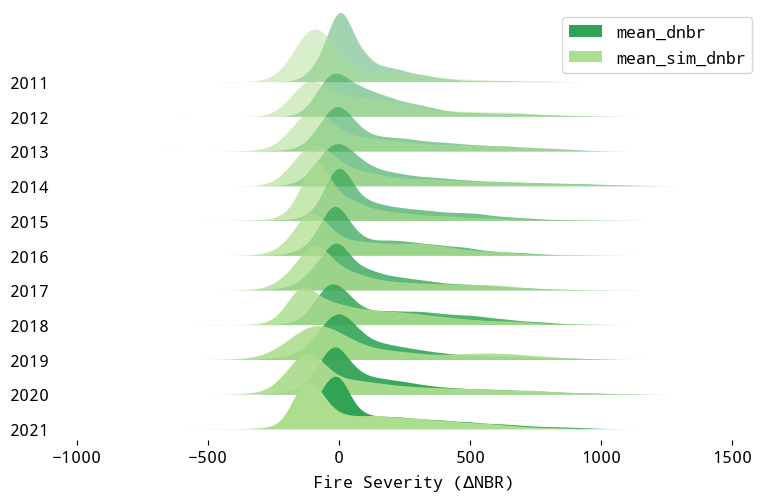

In [37]:
import joypy

dist_state = duckdb.query("""
select year, grid_id, 
    mean(dnbr) as mean_dnbr, 
    mean(sim_dnbr) as mean_sim_dnbr
from df 
where year is not NULL
group by year, grid_id
""")

labels = [str(int(d)) for d in dist_state.to_df().year.unique()]
fig, axes = joypy.joyplot(dist_state.to_df(),
                        by="year", 
                        column=["mean_dnbr", "mean_sim_dnbr"],
                        legend=True,
                        figsize=(8,5),
                        fade=True,
                        overlap=1,
                        linewidth=0,
                        tails=0.1,
                        fill=True,
                        ylim = 'max', 
                        #sublabels = ["$\Delta$NBR", "Simulated $\Delta$NBR"],
                        color=["#31a354", "#addd8e"],
                        )

# Change axis labels
for ax in axes:
    ax.set_xlabel("Fire Severity ($\Delta$NBR)")

# Save plot
#plt.savefig("../figs/dnbr_simulated_joy.png", dpi=300, bbox_inches="tight")

In [43]:
duckdb.query("""
select year, abs(sum(mean_dnbr) - sum(mean_sim_dnbr)) as mean_diff
from dist_state
group by year
order by 1
""")

┌───────┬────────────────────┐
│ year  │     mean_diff      │
│ int32 │       double       │
├───────┼────────────────────┤
│  2011 │ 138993.14988035092 │
│  2012 │ 475646.46745677345 │
│  2013 │  532359.8987698813 │
│  2014 │  426125.2243708744 │
│  2015 │  798226.1822767707 │
│  2016 │  475281.6109229012 │
│  2017 │ 1101374.2484238232 │
│  2018 │  1724339.271534297 │
│  2019 │ 205429.28687882848 │
│  2020 │  4161628.539781339 │
│  2021 │  2144721.829807372 │
├───────┴────────────────────┤
│ 11 rows          2 columns │
└────────────────────────────┘

In [17]:
axes[-1].plot([0, 0], [0, 0], color="#31a354", label="Observed $\Delta$NBR")

In [39]:
duckdb.query("""
select year, count(*) as n, sum(high_severity) as high_severity
from dnbr
group by year 
order by 1
""")

┌───────┬───────┬───────────────┐
│ year  │   n   │ high_severity │
│ int32 │ int64 │    int128     │
├───────┼───────┼───────────────┤
│  2011 │  2211 │             7 │
│  2012 │  4986 │           173 │
│  2013 │  4326 │           242 │
│  2014 │  4328 │           319 │
│  2015 │  6224 │           202 │
│  2016 │  4662 │           121 │
│  2017 │ 11884 │           304 │
│  2018 │ 12523 │           562 │
│  2019 │  2226 │            87 │
│  2020 │ 39587 │          2183 │
│  2021 │ 25849 │          1196 │
├───────┴───────┴───────────────┤
│ 11 rows             3 columns │
└───────────────────────────────┘

In [40]:
duckdb.query("""
select year, count(*) as n, sum(high_severity) as high_severity
from dnbr
group by year 
order by 1
""")

┌───────┬───────┬───────────────┐
│ year  │   n   │ high_severity │
│ int32 │ int64 │    int128     │
├───────┼───────┼───────────────┤
│  2011 │  2211 │             7 │
│  2012 │  4986 │           173 │
│  2013 │  4326 │           242 │
│  2014 │  4328 │           319 │
│  2015 │  6224 │           202 │
│  2016 │  4662 │           121 │
│  2017 │ 11884 │           304 │
│  2018 │ 12523 │           562 │
│  2019 │  2226 │            87 │
│  2020 │ 39587 │          2183 │
│  2021 │ 25849 │          1196 │
├───────┴───────┴───────────────┤
│ 11 rows             3 columns │
└───────────────────────────────┘

In [41]:
duckdb.query("""
with low as (
select 
             *, 
             case 
             when sim_dnbr > 660
             then 1 
             else 0 
             end as high_severity_sim
from df
),
a as (
select year, 
       grid_id,
       mean(high_severity_sim) as high_severity_sim
from low
group by year, grid_id
)
select year, sum(high_severity_sim) as n from a group by year 
order by 1
""")

┌───────┬────────────────────┐
│ year  │         n          │
│ int32 │       double       │
├───────┼────────────────────┤
│  2011 │                3.2 │
│  2012 │  82.88272005772002 │
│  2013 │  86.58851426351428 │
│  2014 │ 219.94311987032577 │
│  2015 │ 55.958349609253176 │
│  2016 │  40.37617953463529 │
│  2017 │ 113.11536795619806 │
│  2018 │ 134.78088419824516 │
│  2019 │  39.85030414688796 │
│  2020 │  1122.985345378247 │
│  2021 │  516.4917666681978 │
├───────┴────────────────────┤
│ 11 rows          2 columns │
└────────────────────────────┘

In [ ]:
from prescribed.plot import template_plots

arr_sim = xr.concat(arr_lst, dim = "sim")
fig, ax = plt.subplots(figsize=(10, 5))
dnbr_arr.mean(dim=["lat", "lon"]).plot(ax=ax, color='gray', linewidth=1, alpha=0.5)
arr_sim.plot.line(x='year', ax=ax, alpha=0.7, linewidth=2)

# Remove the legend
ax.get_legend().remove()

template_plots(ax=ax, ylab=r"$\Delta$NBR", xlab="Year")

# Add all years to the axis
# xinterval = np.arange(2000, 2022) 
# ax.set_xticks(xinterval)
# ax.set_xticklabels(xinterval, va='center')

# Save plot
plt.savefig("../figs/simulations_conifers_6000.png", dpi=300)

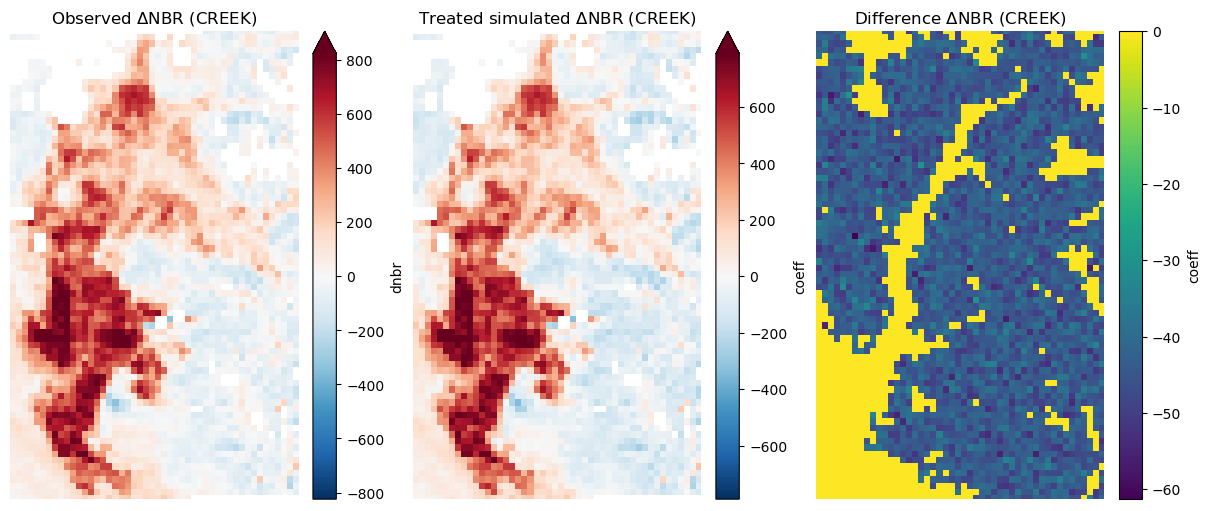

In [86]:
import rioxarray

fig, ax = plt.subplots(1, 3, figsize=(12, 5), layout="constrained")

dnbr_arr.sel(year=2020).plot(ax=ax[0], robust=True)

# Add bounds in x and y
geom = mtbs_ca[mtbs_ca.year == 2020].sort_values("BurnBndAc", ascending=False).iloc[2]
bounds = geom.geometry.bounds 

ax[0].set_xlim(bounds[0], bounds[2])
ax[0].set_ylim(bounds[1], bounds[3])

(dnbr_arr + sim_data).coeff.sel(year=2020).plot(ax=ax[1], robust=True)

ax[1].set_xlim(bounds[0], bounds[2])
ax[1].set_ylim(bounds[1], bounds[3])

sim_data.coeff.sel(year=2020).plot(ax=ax[2])

ax[2].set_xlim(bounds[0], bounds[2])
ax[2].set_ylim(bounds[1], bounds[3])

template_plots(ax=ax[0], no_axis=True, ylab="", xlab="")
template_plots(ax=ax[1], no_axis=True, ylab="", xlab="")
template_plots(ax=ax[2], no_axis=True, ylab="", xlab="")

# Remove titles in ax
ax[0].set_title(rf"Observed $\Delta$NBR ({geom.Incid_Name})")
ax[1].set_title(rf"Treated simulated $\Delta$NBR ({geom.Incid_Name})")
ax[2].set_title(rf"Difference $\Delta$NBR ({geom.Incid_Name})")

# Save plot
plt.savefig("../figs/creek_sims.png", dpi=300)
